# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

## 1. Initial Setup

#### Library

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

#### Spark Setting

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

#### Project Directory

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path name size dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/ Chitra_feature_data/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/ airline_singleday.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/ airlines_3m_features_ext.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/ airlines_3m_full_features.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/ airlines_weather_data/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv airport-timezones.csv 439779 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/ airport_edges/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/ airport_edges_1_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/ airport_edges_3_month/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/ airport_edges_4_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_thruput/ airport_thruput/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices/ airport_vertices/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices_1_year/ airport_vertices_1_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices_3_month/ airport_vertices_3_month/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices_4_year/ airport_vertices_4_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/aw_data_1day/ aw_data_1day/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/chitra_weather_relevant/ chitra_weather_relevant/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/destination_weather_avgs/ destination_weather_avgs/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev.parquet/ dev.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev_flights.parquet/ dev_flights.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev_join.parquet/ dev_join.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev_transformed_Tuesday_2-59.parquet/ dev_transformed_Tuesday_2-59.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flight_full_features.parquet/ flight_full_features.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_features_3_month.parquet/ flights_features_3_month.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_1_year.parquet/ flights_ready_1_year.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_3_month.parquet/ flights_ready_3_month.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_4_year.parquet/ flights_ready_4_year.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_full.parquet/ flights_ready_full.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_1_month_4h.parquet/ join_1_month_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_1_year_4h.parquet/ join_1_year_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_3_month_4h.parquet/ join_3_month_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_4_year_4h.parquet/ join_4_year_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_7_day_4h.parquet/ join_7_day_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_full.parquet/ join_full.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_manual.parquet/ join_manual.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/origin_weather_avgs/ origin_weather_avgs/ 

#### Variables

In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet"
dev_dir = "dev.parquet"
test_dir = "test.parquet"
outcome = 'is_delayed'

# 2. Data

### 1.1 Load the Data

In [0]:
# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data

train_data = loadData(train_dir, 'train_data').cache()

In [0]:
display(train_data)

origin destination year month day_of_month day_of_week crs_dep_time_utc naive_crs_arr_time_utc tail_num op_carrier distance dep_blk dep_del15 nas_delay carrier_delay weather_delay security_delay late_aircraft_delay arr_delay crs_arr_time_utc arr_hour_utc dep_hour_utc hour del_tail_num equipment_delayed dest_pagerank src_pagerank weight avg_trips_per_day avg_tp_per_day avg_flights_per_day avg_car_per_day avg_car_flights_per_day origin_2_wind_angle origin_2_wind_speed origin_2_ceiling origin_2_visibility origin_2_temperature origin_2_dewpoint origin_2_pressure origin_3_wind_angle origin_3_wind_speed origin_3_ceiling origin_3_visibility origin_3_temperature origin_3_dewpoint origin_3_pressure origin_4_wind_angle origin_4_wind_speed origin_4_ceiling origin_4_visibility origin_4_temperature origin_4_dewpoint origin_4_pressure origin_5_wind_angle origin_5_wind_speed origin_5_ceiling origin_5_visibility origin_5_temperature origin_5_dewpoint origin_5_pressure destination_2_wind_angle destination_2_wind_speed destination_2_ceiling destination_2_visibility destination_2_temperature destination_2_dewpoint destination_2_pressure destination_3_wind_angle destination_3_wind_speed destination_3_ceiling destination_3_visibility destination_3_temperature destination_3_dewpoint destination_3_pressure destination_4_wind_angle destination_4_wind_speed destination_4_ceiling destination_4_visibility destination_4_temperature destination_4_dewpoint destination_4_pressure destination_5_wind_angle destination_5_wind_speed destination_5_ceiling destination_5_visibility destination_5_temperature destination_5_dewpoint destination_5_pressure ABE ATL 2015 1 30 5 2015-01-30T11:35:00.000+0000 2015-01-30T14:04:00.000+0000 N603AT DL 692.0 6 0.0 null null null null null -11.0 2015-01-30T14:04:00.000+0000 2015-01-30T14:00:00.000+0000 2015-01-30T11:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.0 8 2.64 2 1.03 751.75 6.7 00792 011265 -20.6 -24.4 1011.9 20.0 6.2 00884 011265 -20.0 -24.4 1012.2 469.6666666666667 7.7 00945 008047 -20.0 -24.4 1013.0 751.75 5.7 00396 009656 -20.0 -24.4 1013.6 330.0 10.3 00732 016093 6.1 -0.6 1021.9 335.0 11.8 00792 016093 8.3 2.2 1021.1 320.0 9.3 00975 016093 10.6 3.9 1020.1 280.0 4.1 01067 016093 12.8 3.3 1019.1 ABE ATL 2015 3 31 2 2015-03-31T16:02:00.000+0000 2015-03-31T18:10:00.000+0000 N916EV EV 692.0 12 0.0 null null null null null -18.0 2015-03-31T18:10:00.000+0000 2015-03-31T18:00:00.000+0000 2015-03-31T16:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.02 8 2.64 4 1.7 275.0 2.6 02134 016093 -12.8 -14.4 1005.2 629.5 3.1 22000 016093 -13.3 -14.4 1005.2 624.5 3.6 22000 016093 -12.8 -13.9 1004.9 275.0 6.2 22000 016093 -11.7 -13.3 1004.7 250.0 3.1 00488 016093 1.0 0.0 1003.2 474.75 1.5 00427 016093 1.0 0.0 1003.1 220.0 1.5 22000 016093 9.4 4.4 1018.3 230.0 1.5 22000 016093 8.9 4.4 1017.8 ABE ATL 2015 4 24 5 2015-04-24T10:40:00.000+0000 2015-04-24T12:47:00.000+0000 N906AT DL 692.0 6 0.0 null null null null null 4.0 2015-04-24T12:47:00.000+0000 2015-04-24T12:00:00.000+0000 2015-04-24T10:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.0 8 2.64 2 1.03 195.0 7.2 01280 016093 2.2 -6.7 1000.9 155.0 5.1 00884 011265 2.8 -6.1 1000.9 210.0 6.2 01189 016093 3.3 -6.7 1001.0 200.0 4.1 01311 016093 3.9 -6.7 1000.8 320.0 3.6 22000 016093 11.1 1.7 1016.0 320.0 4.1 22000 016093 12.2 1.7 1015.8 320.0 4.1 22000 016093 12.8 3.3 1016.0 320.0 4.1 22000 016093 13.3 5.0 1016.2 ABE ATL 2015 5 7 4 2015-05-07T16:02:00.000+0000 2015-05-07T18:08:00.000+0000 N884AS EV 692.0 12 0.0 null null null null null -5.0 2015-05-07T18:08:00.000+0000 2015-05-07T18:00:00.000+0000 2015-05-07T16:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.0 8 2.64 4 1.7 614.5 1.5 01524 016093 6.1 3.3 1006.8 579.5 1.5 01402 016093 4.4 2.8 1007.4 559.5 3.1 01402 016093 5.0 3.3 1007.6 95.0 2.6 01341 016093 5.0 3.9 1007.9 35

In [0]:
train_data.count()

Out[57]: 20409767

## 1.2 Data Analysis

### 1.2.1 Departure delay by delay type

We want to see how much each delay type is contributing to departure delays. We look at all flights that are delayed at the origin by atleast 15 min and increment a counter against the delay type for a given year if the airlines operating the flight reported a specific delay type. Note that a single delayed flight might reports more than one type of delay cause. We then average this yearwise count by the total number of flights for the year to get the percentage delay by delay type.

In [0]:
eda = spark.sql("""
  select concat('year-', t1.year) as year, round(carrier/total * 100, 2) as carrier, round(nas/total * 100,2) as nas, 
    round(weather/total * 100, 2) as weather, round(late_aircraft/total * 100, 2) as late_aircraft
  from
  (select year, count(*) as total
      from train_data
      group by year) t1
  inner join 
  (select year, count(carrier_delay) as carrier
      from train_data
      where carrier_delay > 0 and dep_del15 == 1
      group by year) t2
  on t1.year == t2.year 
  inner join
  (select year, count(nas_delay) as nas
      from train_data
      where nas_delay > 0 and dep_del15 == 1
      group by year) t3
  on t2.year == t3.year
  inner join
  (select year, count(weather_delay) as weather
      from train_data
      where weather_delay > 0 and dep_del15 == 1
      group by year) t4
  on t3.year == t4.year
  inner join
  (select year, count(late_aircraft_delay) as late_aircraft
      from train_data
      where late_aircraft_delay > 0 and dep_del15 == 1
      group by year) t5
   on t4.year == t5.year   
""")
display(eda)

year carrier nas weather late_aircraft year-2018 8.69 6.48 1.15 9.7 year-2015 9.17 6.12 1.06 9.48 year-2016 8.28 5.7 0.84 8.71 year-2017 8.48 6.25 0.83 9.46

From the graph above we can see that the highest departure delay cause reported is for late incoming aircraft, followed by carrier then NAS and finally extreme weather conditions.

### 1.2.2 Departure Delay by Carrier

We want to see which airlines report more departure delays than others. Below graph shows a yearwise distribution of the of departure delay (in log scale) by airline carrier. Note that the numbers for 2018 will be smaller that the other years becuase we only have date for 8 month for 2018 in the training data set. Form the graph below, it appears that Southwest Airlines has the highest number of departure delays followed by American Airlines. Hawaiian Airlines has the lease number of departure delays reported and the magnitude is significantly smaller than that of other airlines. Virgin Atlantic (VX) and Alaska Airlines (AS) show trends that are not in line with the other airlines. This could potentially be due to the 2018 merger of two airlines.

In [0]:
eda = spark.sql("""
select concat('year-',year) as year, op_carrier, count(*) as delays from train_data 
where dep_del15 == 1
group by op_carrier, year
order by delays desc, year asc
""")
display(eda)

year op_carrier delays year-2017 WN 218406 year-2015 WN 203501 year-2016 WN 191192 year-2018 WN 147522 year-2016 AA 124738 year-2017 AA 113824 year-2017 OO 99090 year-2017 DL 97081 year-2015 AA 95718 year-2016 DL 91617 year-2015 DL 89083 year-2018 AA 87990 year-2015 UA 86052 year-2015 EV 82677 year-2015 OO 81627 year-2017 UA 75502 year-2016 UA 74844 year-2016 OO 73544 year-2018 OO 72440 year-2016 EV 68651 year-2018 DL 65731 year-2017 B6 63506 year-2018 UA 60387 year-2017 EV 54068 year-2016 B6 52768 year-2015 MQ 47003 year-2015 B6 45784 year-2018 B6 42927 year-2018 OH 30472 year-2018 MQ 28183 year-2018 YX 27088 year-2015 NK 26988 year-2016 NK 26184 year-2017 NK 24443 year-2015 US 23410 year-2018 9E 23200 year-2018 YV 21816 year-2018 EV 21401 year-2018 F9 18728 year-2015 F9 17909 year-2017 AS 17414 year-2016 F9 16486 year-2017 F9 16392 year-2018 NK 16088 year-2018 AS 15827 year-2017 VX 14936 year-2015 AS 12538 year-2016 AS 11845 year-2016 VX 11627 year-2018 G4 11217 year-2015 VX 8785 year-2018 VX 1706 year-2018 HA 1535 year-2017 HA 1509 year-2015 HA 1097 year-2016 HA 1020

### 1.2.3 Delay by Month

We try to analyze the data for seasonal patterns, to see which months see more delays than the others. We expect to see higher delays during seasons with high air traffic. The graph below shows a yearwise capture of the delays by the month of the year. Note: Data for year 2018 is partially available. The pattern is consitent across the years. From the graph here, we can see that departure delays are high during summer months of Jun through August when people are usually taking vacation around the school summer break and during the winter holiday season. What we see matches our expectation.

In [0]:
eda = spark.sql("""
select year, 
  case
    when month == 1 then '01-Jan'
    when month == 2 then '02-Feb'
    when month == 3 then '03-Mar'
    when month == 4 then '04-Apr'
    when month == 5 then '05-May'
    when month == 6 then '06-Jun'
    when month == 7 then '07-Jul'
    when month == 8 then '08-Aug'
    when month == 9 then '09-Sep'
    when month == 10 then '10-Oct'
    when month == 11 then '11-Nov'
    else '12-Dec'
    end as month, 
  count(*) as delays from train_data 
where dep_del15 == 1
group by month, year
order by year asc
""")
display(eda)

year month delays 2015 04-Apr 61392 2015 01-Jan 72363 2015 06-Jun 93852 2015 09-Sep 44154 2015 03-Mar 73091 2015 07-Jul 86868 2015 11-Nov 52615 2015 10-Oct 44597 2015 02-Feb 72271 2015 08-Aug 74568 2015 12-Dec 76208 2015 05-May 70193 2016 05-May 57652 2016 06-Jun 79489 2016 08-Aug 82594 2016 03-Mar 63107 2016 09-Sep 47254 2016 07-Jul 92816 2016 01-Jan 53287 2016 11-Nov 43248 2016 02-Feb 47052 2016 04-Apr 50655 2016 10-Oct 48024 2016 12-Dec 79338 2017 03-Mar 67124 2017 06-Jun 88597 2017 07-Jul 88833 2017 12-Dec 64052 2017 01-Jan 73755 2017 08-Aug 82763 2017 11-Nov 37962 2017 05-May 76014 2017 10-Oct 52452 2017 02-Feb 46858 2017 09-Sep 44903 2017 04-Apr 72858 2018 06-Jun 106292 2018 03-Mar 74090 2018 11-Nov 82813 2018 08-Aug 113350 2018 05-May 93391 2018 12-Dec 80904 2018 09-Sep 71655 2018 02-Feb 71763

### 1.2.4 Weekday with most delays

In addition to traveling for pleasure, people often travel for business. Air transport has a huge impact on business performance. We analyze the data to see if there are any delay patterns around specific days of the week. Business related travels usually occur just prior to the beginning of a work week and end prior to the end of the work week, typically Thursday or Friday. People traveling for pleasure also typically fly towards end of the work week for shorter trip and perhaps the weekend for longer vacations. Our intuition tells us that we are likely to see more delays on Mondays and Thursday/Friday compared to rest of the week. The graph below shows us the yearwise departure delay by day of week. The graph matches our expectations that delays are more during times of higher air traffic during the beginning and end of workweeks than the middle of the workweek or teh weekend. Also 2015 shows more travel on Thursday compared to Friday.

In [0]:
eda = spark.sql("""
select year, 
case
    when day_of_week == 1 then '01-Mon'
    when day_of_week == 2 then '02-Tue'
    when day_of_week == 3 then '03-Wed'
    when day_of_week == 4 then '04-Thu'
    when day_of_week == 5 then '05-Fri'
    when day_of_week == 6 then '06-Sat'
    else '07-Sun' 
    end as day_of_week, 
count(*) as delays from train_data 
where dep_del15 == 1
group by day_of_week, year
order by delays desc, year asc
""")
display(eda)

year day_of_week delays 2017 05-Fri 136750 2015 01-Mon 131146 2015 04-Thu 130578 2017 01-Mon 129637 2017 04-Thu 127468 2016 05-Fri 126702 2015 05-Fri 124582 2016 04-Thu 122536 2018 05-Fri 122227 2018 04-Thu 122154 2015 02-Tue 118118 2015 03-Wed 118054 2015 07-Sun 114993 2016 01-Mon 112359 2017 07-Sun 109403 2017 03-Wed 107154 2016 07-Sun 105201 2017 02-Tue 102155 2016 02-Tue 99579 2016 03-Wed 98312 2018 01-Mon 96980 2018 03-Wed 96327 2018 07-Sun 91858 2018 02-Tue 89338 2015 06-Sat 84701 2017 06-Sat 83604 2016 06-Sat 79827 2018 06-Sat 75374

### 1.2.5 Delay by Departure Block

We want to see which hour blocks in the day see more delay than others. Intuition says delays would be more during busy hours of the travel and could get progressively worse during second half of the day due to previous backlogs. The graph below shows that as the day progresses, the delays keep accumulating, peaking between 5 pm to 7 pm after which it starts declining.

In [0]:
eda = spark.sql("""
select year, 
case
    when dep_blk >=0 and dep_blk < 10 then concat('Hr-0', dep_blk)
    else concat('Hr-', dep_blk) 
    end as dep_blk, 
count(*) as delays from train_data 
where dep_del15 == 1
group by dep_blk, year
order by year asc
""")
display(eda)

year dep_blk delays 2015 Hr-13 52881 2015 Hr-11 43877 2015 Hr-12 48018 2015 Hr-09 34560 2015 Hr-18 69563 2015 Hr-15 61778 2015 Hr-20 56685 2015 Hr-23 6715 2015 Hr-07 26105 2015 Hr-21 38576 2015 Hr-06 20431 2015 Hr-14 53214 2015 Hr-19 70448 2015 Hr-10 42227 2015 Hr-00 7972 2015 Hr-22 22169 2015 Hr-08 32085 2015 Hr-16 60320 2015 Hr-17 74548 2016 Hr-18 64226 2016 Hr-20 54862 2016 Hr-15 54184 2016 Hr-12 41823 2016 Hr-23 8077 2016 Hr-21 33808 2016 Hr-17 67934 2016 Hr-06 17581 2016 Hr-08 27506 2016 Hr-19 63244 2016 Hr-14 47742 2016 Hr-00 8313 2016 Hr-10 36445 2016 Hr-16 55251 2016 Hr-22 23392 2016 Hr-11 39010 2016 Hr-09 31563 2016 Hr-13 46175 2016 Hr-07 23380 2017 Hr-06 18769 2017 Hr-14 51111 2017 Hr-22 25451 2017 Hr-08 32150 2017 Hr-19 66799 2017 Hr-15 59464 2017 Hr-17 73765 2017 Hr-07 24125 2017 Hr-18 67198 2017 Hr-11 43349 2017 Hr-12 47176 2017 Hr-00 7885 2017 Hr-21 34032 2017 Hr-13 49873 2017 Hr-23 7365 2017 Hr-16 58709 2017 Hr-09 33338 2017 Hr-20 56867 2017 Hr-10 38745 2018 Hr-13 41190 2018 Hr-18 60351 2018 Hr-07 22245 2018 Hr-21 30449 2018 Hr-06 17264 2018 Hr-16 52267 2018 Hr-00 7988 2018 Hr-15 50199 2018 Hr-08 26731 2018 Hr-20 50591 2018 Hr-09 27117 2018 Hr-12 41471 2018 Hr-11 36822 2018 Hr-22 25548 2018 Hr-19 56351 2018 Hr-10 32877 2018 Hr-23 5421 2018 Hr-17 62999 2018 Hr-14 46377

### 2.1 Preprocess and Split Data

We will be doing a time based split to make sure we have a training data, validation data to validate models and the test data,

In [0]:
def preProcessData(dff, outcome = 'is_delayed'):
  # filter out all delays related to security delays
  sec = dff.where('dep_del15 == 1') \
        .where(f.col('security_delay') > 15) \
        .where(f.greatest(*[f.col(x) for x in ['carrier_delay', 'nas_delay', 'weather_delay', 'security_delay', 'late_aircraft_delay']]) == f.col('security_delay'))
  
  dff = dff.subtract(sec)
  
  # Take care of unknown weather values
  # Convert pressure 9999 to null
  for col in [x for x in dff.columns if x.endswith('_pressure')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 9999, None).otherwise(f.col(col)))
    
  # Convert ceiling 99999 to None
  for col in [x for x in dff.columns if x.endswith('_ceiling')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 99999, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_speed')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999.9, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_angle')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999, None).otherwise(f.col(col)))
  
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))
  
  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  dff = dff.withColumn('time_blk', ((dff['dep_blk'].cast(IntegerType()) + 2) / 8).cast(IntegerType()))
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

def partitionData(dff, start_date, end_date):
    return dff.filter(f"make_date(year, month, day_of_month) between '{start_date}' and '{end_date}'")

See how many delayed and on-time flights we have in the training data

In [0]:
train_data = preProcessData(train_data).cache()

In [0]:
display(train_data)

origin destination year month day_of_month day_of_week crs_dep_time_utc naive_crs_arr_time_utc tail_num op_carrier distance dep_blk dep_del15 nas_delay carrier_delay weather_delay security_delay late_aircraft_delay arr_delay crs_arr_time_utc arr_hour_utc dep_hour_utc hour del_tail_num equipment_delayed dest_pagerank src_pagerank weight avg_trips_per_day avg_tp_per_day avg_flights_per_day avg_car_per_day avg_car_flights_per_day origin_2_wind_angle origin_2_wind_speed origin_2_ceiling origin_2_visibility origin_2_temperature origin_2_dewpoint origin_2_pressure origin_3_wind_angle origin_3_wind_speed origin_3_ceiling origin_3_visibility origin_3_temperature origin_3_dewpoint origin_3_pressure origin_4_wind_angle origin_4_wind_speed origin_4_ceiling origin_4_visibility origin_4_temperature origin_4_dewpoint origin_4_pressure origin_5_wind_angle origin_5_wind_speed origin_5_ceiling origin_5_visibility origin_5_temperature origin_5_dewpoint origin_5_pressure destination_2_wind_angle destination_2_wind_speed destination_2_ceiling destination_2_visibility destination_2_temperature destination_2_dewpoint destination_2_pressure destination_3_wind_angle destination_3_wind_speed destination_3_ceiling destination_3_visibility destination_3_temperature destination_3_dewpoint destination_3_pressure destination_4_wind_angle destination_4_wind_speed destination_4_ceiling destination_4_visibility destination_4_temperature destination_4_dewpoint destination_4_pressure destination_5_wind_angle destination_5_wind_speed destination_5_ceiling destination_5_visibility destination_5_temperature destination_5_dewpoint destination_5_pressure time_blk is_delayed ABQ ORD 2015 4 30 4 2015-04-30T19:05:00.000+0000 2015-04-30T22:53:00.000+0000 N505MQ MQ 1118.0 13 1.0 7.0 61.0 0.0 0.0 0.0 68.0 2015-04-30T22:53:00.000+0000 2015-04-30T22:00:00.000+0000 2015-04-30T19:00:00.000+0000 null null 0 10.191810455848527 1.2649364410677846 0.037037037037037035 1.0 56 1.9 2 1.51 null 2.1 22000 16093 292.4 268.6 1013.3 160.0 2.1 22000 16093 289.7 268.6 1013.9 170.0 3.1 22000 16093 288.6 267.4 1013.2 140.0 1.5 22000 16093 285.8 268.6 1013.3 30.0 7.7 914 16093 282.4 274.7 1016.1 30.0 7.2 1250 16093 281.3 274.1 1015.8 30.0 6.7 1036 16093 281.9 273.6 1015.0 20.0 6.7 2438 16093 281.3 273.6 1014.9 1 1 ALB CLT 2018 3 27 2 2018-03-27T12:00:00.000+0000 2018-03-27T14:28:00.000+0000 N553UW AA 646.0 8 0.0 null null null null null -38.0 2018-03-27T14:28:00.000+0000 2018-03-27T14:00:00.000+0000 2018-03-27T12:00:00.000+0000 null null 0 7.042400521922968 0.9802429097855201 0.05 1.0 27 2.63 3 2.68 null 0.0 7925 16093 270.8 264.1 1036.2 null 0.0 22000 16093 271.9 263.6 1036.2 120.0 2.6 22000 16093 273.6 263.0 1036.5 160.0 1.5 22000 16093 273.0 263.0 1037.5 100.0 5.1 1219 16093 279.7 273.6 1031.7 100.0 4.1 1280 16093 280.2 273.6 1031.9 100.0 3.6 1402 16093 281.3 273.0 1032.1 100.0 4.1 1433 16093 281.9 271.9 1032.2 1 0 ALB CLT 2018 9 14 5 2018-09-14T23:27:00.000+0000 2018-09-15T01:30:00.000+0000 N832AW AA 646.0 19 0.0 null null null null null -16.0 2018-09-15T01:30:00.000+0000 2018-09-15T01:00:00.000+0000 2018-09-14T23:00:00.000+0000 null null 0 7.042400521922968 0.9802429097855201 0.05 1.0 27 2.63 3 2.68 190.0 4.6 22000 16093 299.1 291.3 1022.4 200.0 3.6 22000 16093 299.7 291.3 1022.6 206.66666666666666 3.1 853 16093 298.6 291.0 1023.2 574.5 1.5 22000 16093 298.0 290.8 1023.8 360.0 8.8 1372 16093 300.8 295.2 1009.9 10.0 10.3 975 16093 300.2 294.7 1010.1 10.0 7.2 853 16093 300.2 294.7 1010.6 10.0 9.3 853 16093 300.2 295.2 1011.4 2 0 ALB EWR 2016 1 4 1 2016-01-04T19:32:00.000+0000 2016-01-04T20:35:00.000+0000 N13118 EV 143.0 14 0.0 20.0 0.0 0.0 0.0 0.0 20.0 2016-01-04T20:35:00.000+0000 2016-01-04T20:00:00.000+0000 2016-01-04T19:00:00.000+0000 null null 0 4.275907721569275 0.9802429097855201 0.05 1.0 27 1.28 3 1.31 355.0 6.2 671 3219 263.0 257.4 1022.2 74.0 6.2 396 1207 263.0 258.0 1021.9 315.0 6.2 610 2414 263.0 258.6 1021.3 300.0 6.2 762 4828 263.6 258.0 1020.0 350.0 7.7 22000 16093 272.4 257.

In [0]:
train_data.groupBy(outcome).count().show()

+----------+--------+
is_delayed| count|
+----------+--------+
 1| 3057117|
 0|17352650|
+----------+--------+

## 1.3 Histogram of Features

In [0]:
import seaborn as sns
sns.set(style="white")

#train_df = train_data.sample(withReplacement=False, fraction=0.01).toPandas()
train_df = train_data.where('day_of_month == 15').toPandas()

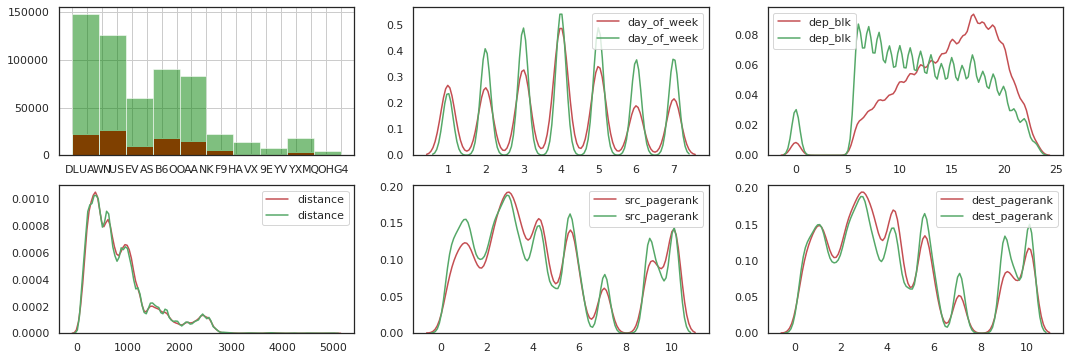

In [0]:
cols = ['op_carrier','day_of_week', 'dep_blk', 'distance', 'src_pagerank', 'dest_pagerank']

n = 3
# plot linear graphs of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(int(len(cols)/n), n, figsize=(18,6))
for idx, feature in enumerate(cols):
  if idx > len(cols) - 1:
    break
  if idx == 0:
    train_df.loc[train_df['dep_del15'] == 1]['op_carrier'].hist(color = 'red', alpha=1, ax=ax_grid[idx//n][idx%n])
    train_df.loc[train_df['dep_del15'] == 0]['op_carrier'].hist(color = 'green',alpha=0.5, ax=ax_grid[idx//n][idx%n])
  else:
    sns.kdeplot(train_df.loc[train_df['dep_del15'] == 1][feature],ax=ax_grid[idx//n][idx%n], color="r")
    sns.kdeplot(train_df.loc[train_df['dep_del15'] == 0][feature], ax=ax_grid[idx//n][idx%n], color="g")
  
#g = sns.PairGrid(train_df[cols], hue="dep_del15")
#g.map_diag(sns.distplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

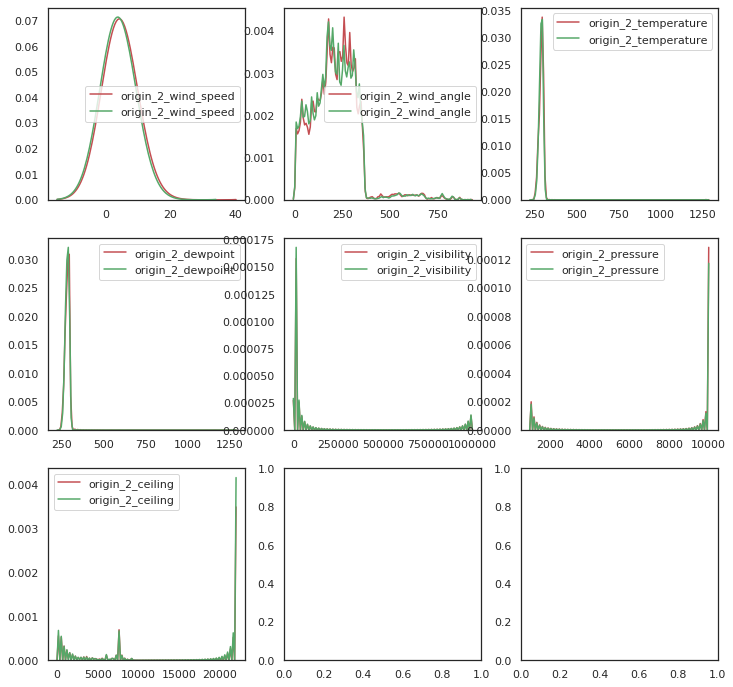

In [0]:
cols = ['origin_2_wind_speed', 'origin_2_wind_angle', 'origin_2_temperature', 'origin_2_dewpoint', 
        'origin_2_visibility', 'origin_2_pressure', 'origin_2_ceiling' ]
n = 3
# plot linear graphs of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(n, n, figsize=(12,12))
for idx, feature in enumerate(cols):
    sns.kdeplot(train_df.loc[train_df['dep_del15'] == 1][feature],ax=ax_grid[idx//n][idx%n], color="r", bw=5)
    sns.kdeplot(train_df.loc[train_df['dep_del15'] == 0][feature], ax=ax_grid[idx//n][idx%n], color="g", bw=5)

Out[62]:

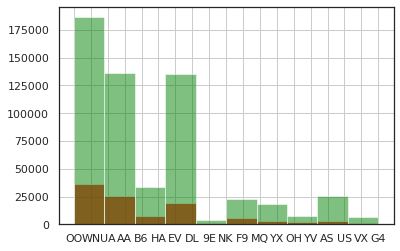

<matplotlib.axes._subplots.AxesSubplot at 0x7fc06bdead50>

In [0]:
train_df.loc[train_df['dep_del15'] == 1]['op_carrier'].hist(color = 'red', alpha=0.75)
train_df.loc[train_df['dep_del15'] == 0]['op_carrier'].hist(color = 'green',alpha=0.5)


Out[67]:

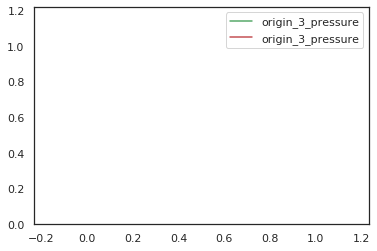

<matplotlib.axes._subplots.AxesSubplot at 0x7fc06b88f750>

In [0]:
sns.kdeplot(train_df.loc[train_df['dep_del15'] == 0]['origin_2_pressure'], color="g")
sns.kdeplot(train_df.loc[train_df['dep_del15'] == 1]['origin_3_pressure'], color="r")